In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFECV
import scipy.stats as st
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [3]:
train = pd.read_csv('/content/drive/MyDrive/MLP Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLP Project/test.csv')
train = train[train.columns[1:]]
test = test[test.columns[1:]]
cols = test.columns

In [4]:
d = {'v_1': 'Binary',
'v_26': 'Binary',
'v_11': 'Binary',
'v_14': 'Binary',
'v_30': 'Binary', 'v_28': 'Binary', 'v_9': 'Binary', 'v_27': 'Binary',
'v_32': 'Nominal', 'v_4': 'Nominal',
'v_3': 'Nominal',
'v_20': 'Nominal',
'v_21': 'Nominal',
'v_18': 'Nominal',
'v_25': 'Nominal',
'v_12': 'Nominal', 'v_31': 'Ordinal',
'v_15': 'Ordinal',
'v_19': 'Ordinal',
'v_13': 'Ordinal',
'v_33': 'Ordinal',
'v_17': 'Ordinal',
'v_29': 'Ordinal',
'v_23': 'Ordinal',
'v_6': 'Ordinal', 'v_24': 'Ordinal', 'v_10': 'Ordinal', 'v_5': 'Ordinal',
'v_22': 'Ordinal', 'v_0': 'Ordinal',
'v_16': 'Ratio',
'v_2': 'Ratio',
'v_8': 'Ratio',
'v_7': 'Ratio' ,'v_34': 'Ratio', 'v_35': 'Ratio' ,'v_36': 'Ratio' ,'v_37': 'Ratio' ,'v_38': 'Ratio' ,'v_39': 'Ratio' ,'v_40': 'Ratio'}
types = list(set([value for key,value in d.items()]))
d = {k:[key for key,values in d.items() if values==k] for k in types}
numerical = d['Ratio']
nominal = d['Nominal']
ordinal = d['Ordinal']
binary = d['Binary']

In [5]:
X,Y = train.iloc[:,:-1], train.iloc[:,-1]

In [6]:
X,Y = SMOTE(sampling_strategy='not majority',random_state=42).fit_resample(X,Y)

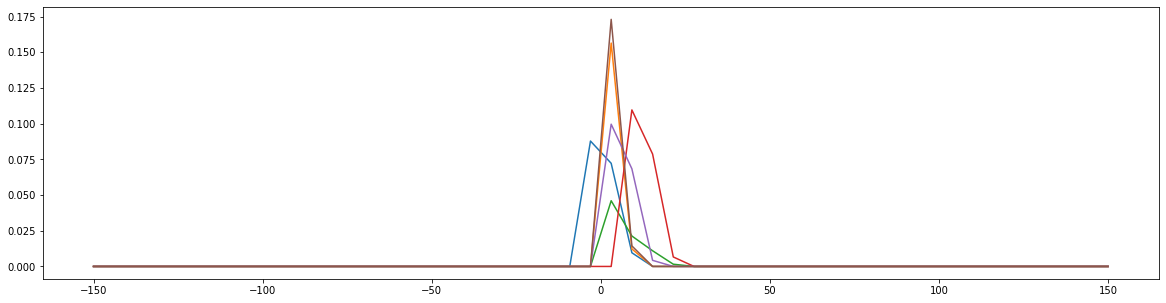

In [7]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
normal = []
for i in range(len(numerical)):
  x = X[numerical[i]]
  eval_points = np.linspace(-150, 150)
  kernel = st.gaussian_kde(x)
  y = kernel.pdf(eval_points)
  if np.max(y) < 0.04:
    continue
  normal.append(numerical[i])
  plt.plot(eval_points, y)
minmax = list(set(numerical) - set(normal)) 

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)

In [9]:
ct = ColumnTransformer([("normal", StandardScaler(), normal),
                        ("minmax", MinMaxScaler(), minmax),
                        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal+nominal),
                        ("binary", 'passthrough', binary)])
le = LabelEncoder()
X_train_transformed = ct.fit_transform(X_train)
Y_train_transformed = le.fit_transform(Y_train)
X_test_transformed = ct.transform(X_test)
Y_test_transformed = le.transform(Y_test)

In [10]:
def Testing(estimator, X_train, Y_train, X_test, Y_test):
  est = estimator.fit(X_train, Y_train)
  Y_pred = est.predict(X_test)
  score = f1_score(Y_test_transformed,est.predict(X_test_transformed), average='weighted')
  print(classification_report(Y_test_transformed,est.predict(X_test_transformed)))
  print(score)
  return score

In [11]:
def Validation(estimator, X, Y):
  v = []
  rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
  for train, test in rskf.split(X,Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    Y_train, Y_test = Y.iloc[train], Y.iloc[test]
    X_train_transformed = ct.fit_transform(X_train)
    Y_train_transformed = le.fit_transform(Y_train)
    X_test_transformed = ct.transform(X_test)
    Y_test_transformed = le.transform(Y_test)
    estimator.fit(X_train_transformed, Y_train_transformed)
    v.append(f1_score(Y_test_transformed, estimator.predict(X_test_transformed),average='weighted'))
  return np.mean(np.asarray(v))

In [12]:
gcb = GradientBoostingClassifier(n_estimators=1000, min_samples_leaf=30,
                                 min_samples_split=400, random_state=42, 
                                 validation_fraction=0.1, n_iter_no_change=10)
gcb.fit(X_train_transformed, Y_train_transformed)

GradientBoostingClassifier(min_samples_leaf=30, min_samples_split=400,
                           n_estimators=1000, n_iter_no_change=10,
                           random_state=42)

In [13]:
Testing(gcb,X_train_transformed,Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       372
           1       0.80      0.85      0.82       373
           2       0.73      0.72      0.73       373

    accuracy                           0.77      1118
   macro avg       0.77      0.77      0.77      1118
weighted avg       0.77      0.77      0.77      1118

0.771242714854862


0.771242714854862

In [18]:
Validation(gcb,X,Y)

0.7785099279423134

In [41]:
gcb = GradientBoostingClassifier(random_state=42, validation_fraction=0.1, 
                                 n_iter_no_change=10)
params = {'n_estimators':np.linspace(100,10000,num=100).astype(int),
          'min_samples_leaf':np.linspace(10,100,num=10).astype(int),
          'min_samples_split':np.linspace(50,500,num=10).astype(int)}
rscv = RandomizedSearchCV(gcb,params,random_state=42,scoring='f1_weighted',
                          n_iter=100,cv=5, verbose=3, return_train_score=True)
rscv.fit(X_train_transformed, Y_train_transformed)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END min_samples_leaf=80, min_samples_split=150, n_estimators=7100;, score=(train=0.867, test=0.771) total time=   8.8s
[CV 2/5] END min_samples_leaf=80, min_samples_split=150, n_estimators=7100;, score=(train=0.882, test=0.794) total time=   8.3s
[CV 3/5] END min_samples_leaf=80, min_samples_split=150, n_estimators=7100;, score=(train=0.894, test=0.775) total time=   9.2s
[CV 4/5] END min_samples_leaf=80, min_samples_split=150, n_estimators=7100;, score=(train=0.886, test=0.778) total time=   9.3s
[CV 5/5] END min_samples_leaf=80, min_samples_split=150, n_estimators=7100;, score=(train=0.866, test=0.773) total time=   6.5s
[CV 1/5] END min_samples_leaf=10, min_samples_split=450, n_estimators=6100;, score=(train=0.877, test=0.778) total time=   8.8s
[CV 2/5] END min_samples_leaf=10, min_samples_split=450, n_estimators=6100;, score=(train=0.889, test=0.778) total time=  10.4s
[CV 3/5] END min_samples_leaf=10, min_sam

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(n_iter_no_change=10,
                                                        random_state=42),
                   n_iter=100,
                   param_distributions={'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_split': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                        'n_estimators': array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  1100,  1200,  1300,  1400,  1500,  1600,...
        4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,  5400,
        5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,  6300,
        6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,  7200,
        7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,  8100,
        8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,  9000,
        9100,  9200

In [42]:
bgcb = rscv.best_estimator_

In [43]:
Testing(bgcb,X_train_transformed,Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       372
           1       0.77      0.85      0.81       373
           2       0.71      0.72      0.71       373

    accuracy                           0.76      1118
   macro avg       0.76      0.76      0.76      1118
weighted avg       0.76      0.76      0.76      1118

0.7566234056069441


0.7566234056069441

In [44]:
bgcb

GradientBoostingClassifier(min_samples_leaf=60, min_samples_split=150,
                           n_estimators=7700, n_iter_no_change=10,
                           random_state=42)

In [45]:
x = GradientBoostingClassifier(min_samples_leaf=30, min_samples_split=50,
                           n_estimators=4800, n_iter_no_change=10,
                           random_state=42)
Testing(x,X_train_transformed,Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       372
           1       0.78      0.85      0.81       373
           2       0.73      0.73      0.73       373

    accuracy                           0.77      1118
   macro avg       0.77      0.77      0.77      1118
weighted avg       0.77      0.77      0.77      1118

0.767484205133556


0.767484205133556